### Задача определения частей речи, Part-Of-Speech Tagger (POS)

с помощью скрытой марковской модели (HMM).

In [1]:
import time
import math
import copy
import nltk
import torch
import torchtext
import matplotlib
import numpy as np
import pandas as pd
from torch import nn
import torch.optim as optim
from nltk.corpus import brown
import matplotlib.pyplot as plt
from nltk.tag import DefaultTagger
from IPython.display import clear_output
from collections import OrderedDict, deque
from sklearn.model_selection import train_test_split
from torchtext.legacy.data import Field, BucketIterator

matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline

Загрузим brown корпус

In [2]:
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\lugre\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

Существует множество наборов грамматических тегов, или тегсетов, например:
* НКРЯ
* Mystem
* UPenn
* OpenCorpora (его использует pymorphy2)
* Universal Dependencies

На данный момент стандартом является **Universal Dependencies**. Подробнее про проект можно почитать [вот тут](https://universaldependencies.org/), а про теги — [вот тут](https://universaldependencies.org/u/pos/)

In [3]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\lugre\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

Мы имеем массив предложений пар (слово-тег)

In [4]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
brown_tagged_sents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [5]:
print(f'Всего {len(brown_tagged_sents)} предложений-пар в массиве')

Всего 57340 предложений-пар в массиве


Первое предложение

In [6]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Все пары (слово-тег)

In [7]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

In [8]:
print(f'Всего {len(brown_tagged_words)} пар слово-тег в массиве')

Всего 1161192 пар слово-тег в массиве


Проанализируем данные

In [9]:
# Приведем слова к нижнему регистру
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [10]:
tags = [tag for (word, tag) in brown_tagged_words]    # наши теги
words = [word for (word, tag) in brown_tagged_words]  # наши слова

In [11]:
tag_num = pd.Series(nltk.FreqDist(tags)).sort_values(ascending=False)    # тег - кол-во тега в корпусе
word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False)  # слово - кол-во слова в корпусе

Корпус содержит следующий перечень тегов:

- ADJ: **adjective** - прилагательное 
- ADP: **adposition** - предлоги и послелоги
- ADV: **adverb** - наречие
- CONJ: **coordinating conjunction** - союз
- DET: **determiner** - определяющее слово
- NOUN: **noun** - существительное
- NUM: **numeral** - числительное
- PRT: **particle** - частица
- PRON: **pronoun** - местоимение
- .: **punctuation** - знак пунктуации
- VERB: **verb** - глагол
- X: **other** - другое

In [12]:
tag_num

NOUN    275558
VERB    182750
.       147565
ADP     144766
DET     137019
ADJ      83721
ADV      56239
PRON     49334
CONJ     38151
PRT      29829
NUM      14874
X         1386
dtype: int64

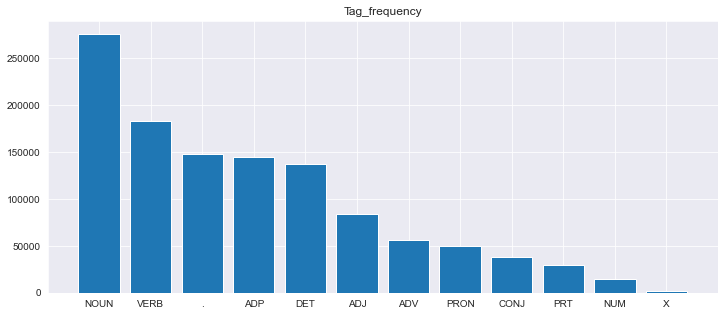

In [13]:
plt.figure(figsize=(12, 5))
plt.bar(tag_num.index, tag_num.values)
plt.title("Tag_frequency")
plt.show()

In [14]:
word_num[:10]

the     69971
,       58334
.       49346
of      36412
and     28853
to      26158
a       23195
in      21337
that    10594
is      10109
dtype: int64

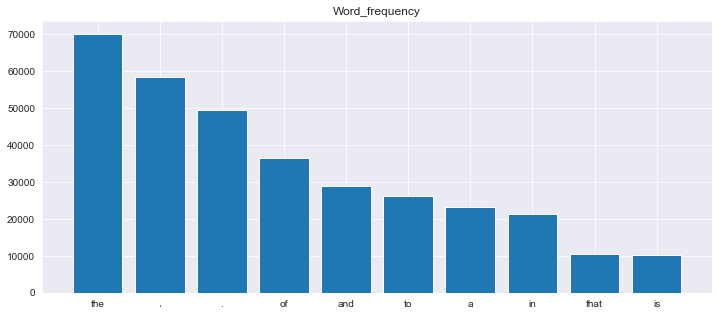

In [15]:
plt.figure(figsize=(12, 5))
plt.bar(word_num.index[:10], word_num.values[:10])
plt.title("Word_frequency")
plt.show()

Самое популярное слово с самым популярным тегом:

In [17]:
# список слов встречающихся с самым популярным тегом
words_with_popular_tag = [word for word, tag in brown_tagged_words if tag == tag_num.index[0]]
words_with_popular_tag[:5]

['fulton', 'county', 'jury', 'friday', 'investigation']

In [18]:
# кол-во слов встречающихся с самым популярным тегом
words_with_popular_tag_num = pd.Series(nltk.FreqDist(words_with_popular_tag)).sort_values(ascending=False)
words_with_popular_tag_num[:5]

time     1597
man      1203
af        995
years     949
way       899
dtype: int64

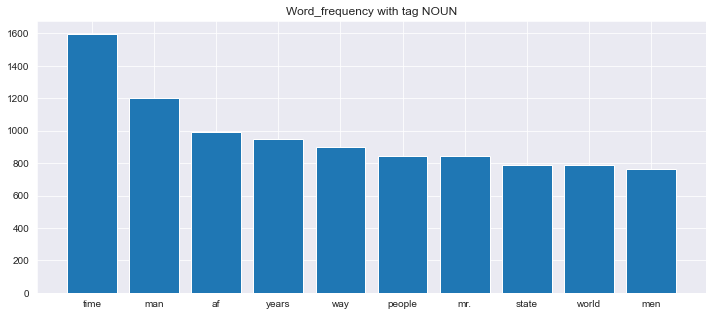

In [19]:
plt.figure(figsize=(12, 5))
plt.bar(words_with_popular_tag_num.index[:10], words_with_popular_tag_num.values[:10])
plt.title(f"Word_frequency with tag {tag_num.index[0]}")
plt.show()

In [20]:
print(f"С самым популярным тегом '{tag_num.index[0]}' чаще всего встречается слово '{words_with_popular_tag_num.index[0]}'")

С самым популярным тегом 'NOUN' чаще всего встречается слово 'time'


Обучение моделей может занимать слишком много времени, поэтому будем работать с подвыборкой

Категории нашего корпуса:

In [21]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

#### Humor

Будем работать с категорией humor

In [22]:
brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')
brown_tagged_sents

[[('It', 'PRON'), ('was', 'VERB'), ('among', 'ADP'), ('these', 'DET'), ('that', 'ADP'), ('Hinkle', 'NOUN'), ('identified', 'VERB'), ('a', 'DET'), ('photograph', 'NOUN'), ('of', 'ADP'), ('Barco', 'NOUN'), ('!', '.'), ('!', '.')], [('For', 'ADP'), ('it', 'PRON'), ('seems', 'VERB'), ('that', 'ADP'), ('Barco', 'NOUN'), (',', '.'), ('fancying', 'VERB'), ('himself', 'PRON'), ('a', 'DET'), ("ladies'", 'NOUN'), ('man', 'NOUN'), ('(', '.'), ('and', 'CONJ'), ('why', 'ADV'), ('not', 'ADV'), (',', '.'), ('after', 'ADP'), ('seven', 'NUM'), ('marriages', 'NOUN'), ('?', '.'), ('?', '.')], ...]

In [23]:
print(f"Всего {len(brown_tagged_sents)} предложений-пар в массиве в категории 'humor'")

Всего 1053 предложений-пар в массиве в категории 'humor'


In [24]:
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []

for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))

my_brown_tagged_sents = np.array(my_brown_tagged_sents, dtype=object)
my_brown_tagged_sents[:5]

array([list([('it', 'PRON'), ('was', 'VERB'), ('among', 'ADP'), ('these', 'DET'), ('that', 'ADP'), ('hinkle', 'NOUN'), ('identified', 'VERB'), ('a', 'DET'), ('photograph', 'NOUN'), ('of', 'ADP'), ('barco', 'NOUN'), ('!', '.'), ('!', '.')]),
       list([('for', 'ADP'), ('it', 'PRON'), ('seems', 'VERB'), ('that', 'ADP'), ('barco', 'NOUN'), (',', '.'), ('fancying', 'VERB'), ('himself', 'PRON'), ('a', 'DET'), ("ladies'", 'NOUN'), ('man', 'NOUN'), ('(', '.'), ('and', 'CONJ'), ('why', 'ADV'), ('not', 'ADV'), (',', '.'), ('after', 'ADP'), ('seven', 'NUM'), ('marriages', 'NOUN'), ('?', '.'), ('?', '.')]),
       list([(')', '.'), (',', '.'), ('had', 'VERB'), ('listed', 'VERB'), ('himself', 'PRON'), ('for', 'ADP'), ('mormon', 'NOUN'), ('beard', 'NOUN'), ('roles', 'NOUN'), ('at', 'ADP'), ('the', 'DET'), ('instigation', 'NOUN'), ('of', 'ADP'), ('his', 'DET'), ('fourth', 'ADJ'), ('murder', 'NOUN'), ('victim', 'NOUN'), ('who', 'PRON'), ('had', 'VERB'), ('said', 'VERB'), (':', '.'), ('``', '.'), ('

In [25]:
# Выполним разбиение в пропорции 9:1
train_sents, test_sents = train_test_split(my_brown_tagged_sents, test_size=0.1, random_state=0)

In [26]:
len(train_sents)

947

In [27]:
len(test_sents)

106

### Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов (матрица A).


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово" (матрица B).


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot
p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1)
= (\text{в силу условий нашей модели}) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$ <br>
Для последовательности длины $n + 1$:<br>
$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

#### Алгоритм Витерби для применения модели


Это алгоритм динамического программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [28]:
class HiddenMarkovModel:
    def __init__(self):
        pass

    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train)
        """
        tags = [tag for sent in train_tokens_tags_list
                for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list
                 for (word, tag) in sent]

        tag_num = pd.Series(nltk.FreqDist(tags)).sort_values(ascending=False)
        word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False)

        self.tags = tag_num.index
        self.words = word_num.index

        A = pd.DataFrame(data={'{}'.format(tag) : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame(data={'{}'.format(tag) : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)

        # Вычисляем матрицы A и B по частотам слов и тегов
        # sent - предложение
        # sent[i][0] - i слово в этом предложении, sent[i][1] - i тег в этом предложении
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                B.loc[sent[i][0], sent[i][1]] += 1          # текущая i-пара слово-тег (обновите матрицу B аналогично A)
                if len(sent) - 1 != i:                      # для последнего тега нет следующего тега
                    A.loc[sent[i][1], sent[i + 1][1]] += 1  # пара тег-тег

        # переходим к вероятностям
        # нормируем по строке, то есть по всем всевозможным следующим тегам
        A = A.divide(A.sum(axis=1), axis=0)

        # нормируем по столбцу, то есть по всем всевозможным текущим словам
        B = B.divide(B.sum(axis=0), axis=1)

        self.A = A
        self.B = B

        return self

    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений пар слово-тег (выборка для test)
        """
        # работаем с копией данных
        test_tokens_list = copy.deepcopy(test_tokens_list)

        predict_tags = OrderedDict({i : np.array([]) for i in range(len(test_tokens_list))})

        for i_sent, current_sent in enumerate(test_tokens_list):
            len_sent = len(current_sent)  # длина предложения

            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1  # нулевое состояние (равномерная инициализация по всем s)
            back_point = np.zeros(shape=(len_sent + 1, len(self.tags)))  # argmax

            for t in range(len_sent):
                # если мы не встречали такое слово в обучении, то вместо него будет
                # самое популярное слово с самым популярным тегом (вопрос 2)
                if current_sent[t] not in self.words:
                    current_sent[t] = self.B.loc[:, self.tags[0]].idxmax()

                # через max выбираем следующий тег
                for i_s, s in enumerate(self.tags):
                    # формула (1)
                    q[t + 1][i_s] = np.max(q[t] *
                                           self.A.loc[:, s] *
                                           self.B.loc[current_sent[t], s])

                    # argmax, формула(1)
                    # argmax, чтобы восстановить последовательность тегов
                    back_point[t + 1][i_s] = (q[t] *
                                              self.A.loc[:, s] *
                                              self.B.loc[current_sent[t], s]) \
                                              .reset_index()[s].idxmax()  # индекс

            back_point = back_point.astype('int')

            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]

            predict_tags[i_sent] = np.array(back_tag)

        return predict_tags

Обучим скрытую марковскую модель:

In [29]:
my_model = HiddenMarkovModel()
my_model.fit(train_sents);

Проверьте работу реализованного алгоритма:
- 'He can stay'
- 'a cat and a dog'
- 'I have a television'
- 'My favourite character'

In [30]:
sents = [['He', 'can', 'stay'], ['a', 'cat', 'and', 'a', 'dog'], ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]

sents = [[word.lower() for word in sent] for sent in sents]  # приведём к нижнему регистру
sents

[['he', 'can', 'stay'],
 ['a', 'cat', 'and', 'a', 'dog'],
 ['i', 'have', 'a', 'television'],
 ['my', 'favourite', 'character']]

In [31]:
# сделаем предсказание
sents_predict = my_model.predict(sents)
sents_predict

OrderedDict([(0, array(['PRON', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['PRON', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['DET', 'NOUN', 'NOUN'], dtype='<U4'))])

In [32]:
# теоретически, одно и то же слово может встречаться несколько раз
# в одном и том же предложении и иметь разные части речи
result_sents = {i: {} for i in range(len(sents_predict))}

for i_r, s_r in enumerate(sents):
    for j_r, w_r in enumerate(s_r):
        result_sents[i_r][j_r] = {w_r: sents_predict[i_r][j_r]}

result_sents

{0: {0: {'he': 'PRON'}, 1: {'can': 'VERB'}, 2: {'stay': 'VERB'}},
 1: {0: {'a': 'DET'},
  1: {'cat': 'NOUN'},
  2: {'and': 'CONJ'},
  3: {'a': 'DET'},
  4: {'dog': 'NOUN'}},
 2: {0: {'i': 'PRON'},
  1: {'have': 'VERB'},
  2: {'a': 'DET'},
  3: {'television': 'NOUN'}},
 3: {0: {'my': 'DET'}, 1: {'favourite': 'NOUN'}, 2: {'character': 'NOUN'}}}

Применим модель к отложенной выборке Брауновского корпуса и подсчитаем точность определения тегов (accuracy).

In [35]:
def accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0

    for sent in sents:
        tags = [tag for (word, tag) in sent]
        words = [word for (word, tag) in sent]
        true_pred += sum([True for i,j in zip(tags, model.predict([words])[0]) if i==j])
        num_pred += len(tags)

    print("Accuracy:", np.round(true_pred / num_pred * 100, 1), '%')

In [36]:
accuracy_score(my_model, test_sents)

Accuracy: 88.8 %


#### Full brown corpus

Обучим HiddenMarkovModel на полном корпусе:

In [36]:
brown_tagged_sents_full = brown.tagged_sents(tagset="universal")

In [37]:
# Приведем слова к нижнему регистру
my_brown_tagged_sents_full = []

for sent in brown_tagged_sents_full:
    my_brown_tagged_sents_full.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))

my_brown_tagged_sents_full = np.array(my_brown_tagged_sents_full, dtype=object)
my_brown_tagged_sents_full[:5]

array([list([('the', 'DET'), ('fulton', 'NOUN'), ('county', 'NOUN'), ('grand', 'ADJ'), ('jury', 'NOUN'), ('said', 'VERB'), ('friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]),
       list([('the', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('city', 'NOUN'), ('executive', 'ADJ'), ('committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP')

In [38]:
# Выполним разбиение в пропорции 9:1
train_sents_full, test_sents_full = train_test_split(my_brown_tagged_sents_full, test_size=0.1, random_state=0)

In [39]:
len(train_sents_full)

51606

In [40]:
len(test_sents_full)

5734

In [46]:
my_model_full = HiddenMarkovModel()
my_model_full.fit(train_sents_full);

In [47]:
accuracy_score(my_model_full, test_sents_full)

Accuracy: 96.3 %


## DefaultTagger

Какое качество мы бы получили, если бы предсказывали любой тег, как самый популярный тег на выборке train?

In [41]:
# определим самый популярный тег
most_popular_tag = tag_num.index[0]
most_popular_tag

'NOUN'

In [42]:
# определим tagger
default_tagger = DefaultTagger(most_popular_tag)

#### Способ №1

In [43]:
# уберём теги из датасета train_sents
train_sents_words = [[word for (word, tag) in sent] for sent in train_sents]
# используем метод tag
default_tagger_sents = [default_tagger.tag(sent) for sent in train_sents_words]

default_tagger_sents[0]

[('then', 'NOUN'),
 (',', 'NOUN'),
 ('i', 'NOUN'),
 ('remembered', 'NOUN'),
 ('that', 'NOUN'),
 ('the', 'NOUN'),
 ('girls', 'NOUN'),
 ('had', 'NOUN'),
 ('had', 'NOUN'),
 ('a', 'NOUN'),
 ('banana', 'NOUN'),
 ('for', 'NOUN'),
 ('dessert', 'NOUN'),
 ('every', 'NOUN'),
 ('day', 'NOUN'),
 ('for', 'NOUN'),
 ('the', 'NOUN'),
 ('last', 'NOUN'),
 ('week', 'NOUN'),
 ('.', 'NOUN')]

In [44]:
def accuracy_score_tag(predicted_sents, sents):
    true_pred = 0
    num_pred = 0

    for i_s, sent in enumerate(sents):
        for j_w, word in enumerate(sent):
            true_tag = word[1]
            predicted_tag = predicted_sents[i_s][j_w][1]
            if predicted_tag == true_tag:
                true_pred += 1
            num_pred += 1

    print("Accuracy:", np.round(true_pred / num_pred * 100, 1), '%')

In [45]:
accuracy_score_tag(default_tagger_sents, train_sents)

Accuracy: 20.3 %


#### Способ №2

In [46]:
# оптимальный вариант с помощью evaluate
tagger_score = default_tagger.evaluate(train_sents)
print("Accuracy:", np.round(tagger_score * 100, 1), '%')

Accuracy: 20.3 %


## NLTK, Rnnmorph

#### NLTK

In [48]:
# from nltk.tag.mapping import map_tag
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lugre\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [49]:
# уберём теги из датасета humor
my_brown_tagged_words = [[word for (word, tag) in sent] for sent in my_brown_tagged_sents]
nltk_predict = [nltk.pos_tag(sent, tagset='universal') for sent in my_brown_tagged_words]
nltk_predict[0]

[('it', 'PRON'),
 ('was', 'VERB'),
 ('among', 'ADP'),
 ('these', 'DET'),
 ('that', 'DET'),
 ('hinkle', 'VERB'),
 ('identified', 'VERB'),
 ('a', 'DET'),
 ('photograph', 'NOUN'),
 ('of', 'ADP'),
 ('barco', 'NOUN'),
 ('!', '.'),
 ('!', '.')]

In [50]:
accuracy_score_tag(nltk_predict, my_brown_tagged_sents)

Accuracy: 89.3 %


#### Rnnmorph

In [57]:
from rnnmorph.predictor import RNNMorphPredictor
predictor = RNNMorphPredictor(language="en")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lugre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lugre\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\lugre\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [58]:
rnnmorph_result = [predictor.predict(sent) for sent in my_brown_tagged_words]
rnnmorph_predict = [[(token.word, token.pos) for token in sent] for sent in rnnmorph_result]
rnnmorph_predict[0]

[('it', 'PRON'),
 ('was', 'VERB'),
 ('among', 'ADP'),
 ('these', 'PRON'),
 ('that', 'DET'),
 ('hinkle', 'NOUN'),
 ('identified', 'VERB'),
 ('a', 'DET'),
 ('photograph', 'NOUN'),
 ('of', 'ADP'),
 ('barco', 'NOUN'),
 ('!', 'PUNCT'),
 ('!', 'PUNCT')]

In [59]:
accuracy_score_tag(rnnmorph_predict, my_brown_tagged_sents)

Accuracy: 63.4 %


В категории humor, библиотека NLTK показала значение точности в 89.3%. В свою очередь библиотека Rnnmorph показала ожидаемо худшее качество, равное 63.4%.

## BiLSTMTagger

### Humor

### Подготовка данных

Изменим структуру данных

In [47]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
print(pos_data[0])

[('It', 'was', 'among', 'these', 'that', 'Hinkle', 'identified', 'a', 'photograph', 'of', 'Barco', '!', '!'), ('PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.')]


In [48]:
# наши поля
WORD = Field(lower=True)
TAG = Field(unk_token=None)  # все токены нам известны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(torchtext.legacy.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

In [49]:
print(vars(examples[0]))

{'words': ['it', 'was', 'among', 'these', 'that', 'hinkle', 'identified', 'a', 'photograph', 'of', 'barco', '!', '!'], 'tags': ['PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.']}


Теперь формируем наш датасет

In [50]:
# кладем примеры в наш датасет
dataset = torchtext.legacy.data.Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 842
Number of validation examples: 106
Number of testing examples: 105


Построим словари. При построении словаря используем только **train**

In [51]:
WORD.build_vocab(train_data, min_freq=1)
TAG.build_vocab(train_data)

print(f"Unique tokens in source (ru) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (ru) vocabulary: 4020
Unique tokens in target (en) vocabulary: 13
['<unk>', 'wife', 'come', 'late', 'chateau', 'living', 'superseded', 'aquacutie', 'bump', 'contradiction', 'divinity', 'fills', 'head-tossing', 'kate', 'mice', 'package', 'purchased', 'sadistic', 'spree', 'trips', 'wrong']
['<pad>', 'NOUN', 'VERB', '.', 'DET', 'ADP', 'ADJ', 'PRON', 'ADV', 'CONJ', 'PRT', 'NUM', 'X']


In [52]:
print(vars(train_data.examples[9]))

{'words': ['ambiguity'], 'tags': ['NOUN']}


Посмотрим с насколько большими предложениями мы имеем дело

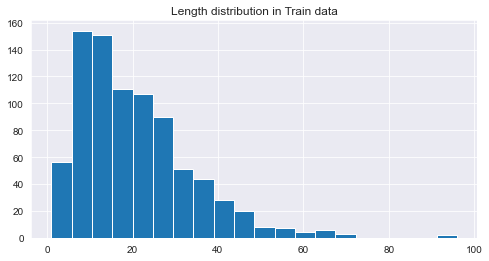

In [53]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Для более быстрого и устойчивого обучения сгруппируем наши данные по батчам

In [55]:
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32

In [56]:
# разобьем нашу выборку на батчи, не забывая сначала отсортировать выборку по длине
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=_len_sort_key)

In [57]:
# посморим  на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[27, 4, 4]

### Модель и её обучение

Инициализируем нашу модель

In [58]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, dropout, bidirectional=False):
        super().__init__()

        self.embeddings = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.rnn = nn.LSTM(input_size=emb_dim,
                           hidden_size=hid_dim,
                           num_layers=2,
                           batch_first=False,
                           dropout=0,
                           bidirectional=bidirectional)

        # если bidirectional, то предсказываем на основе конкатенации двух hidden
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)

    def forward(self, sent):
        # sent = [sent len, batch size]

        # не забываем применить dropout к embedding
        embedded = self.dropout(self.embeddings(sent))
        # embedded = [sent len, batch size, emb_dim]

        output, _ = self.rnn(embedded)
        # output = [sent len, batch size, hid dim * n directions]

        prediction = self.tag(output)
        # prediction = [sent len, batch size, output_dim]

        return prediction

In [59]:
# параметры модели
INPUT_DIM = len(WORD.vocab)
OUTPUT_DIM = len(TAG.vocab)
EMB_DIM = 256
HID_DIM = 512
DROPOUT = 0.2
BIDIRECTIONAL = True

In [60]:
model = LSTMTagger(input_dim=INPUT_DIM,
                   emb_dim=EMB_DIM,
                   hid_dim=HID_DIM,
                   output_dim=OUTPUT_DIM,
                   dropout=DROPOUT,
                   bidirectional=BIDIRECTIONAL).to(device)

In [61]:
# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

In [62]:
model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(4020, 256)
  (dropout): Dropout(p=0.2, inplace=False)
  (rnn): LSTM(256, 512, num_layers=2, bidirectional=True)
  (tag): Linear(in_features=1024, out_features=13, bias=True)
)

Подсчитаем количество обучаемых параметров нашей модели

In [63]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [64]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,496,013 trainable parameters


In [65]:
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [73]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):

    model.train()
    epoch_loss = 0
    history = []

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()

        words = vars(batch)['words']              # [sent len, batch size]
        tags = vars(batch)['tags']                # [sent len, batch size]

        output = model(words)                     # [sent len, batch size, output dim]

        output = output.view(-1, output.size(2))  # [sent len * batch size, output dim]
        tags = tags.view(-1)                      # [sent len * batch size]

        loss = criterion(output, tags)
        loss.backward()

        # Gradient clipping(решение проблемы взрыва граденты), clip - максимальная норма вектора
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        optimizer.step()

        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())

        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')

            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            plt.show()

    return epoch_loss / len(iterator)

In [74]:
def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            words = vars(batch)['words']              # [sent len, batch size]
            tags = vars(batch)['tags']                # [sent len, batch size]

            output = model(words)                     # [sent len, batch size, output dim]

            output = output.view(-1, output.size(2))  # [sent len * batch size, output dim]
            tags = tags.view(-1)                      # [sent len * batch size]

            loss = criterion(output, tags)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [75]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

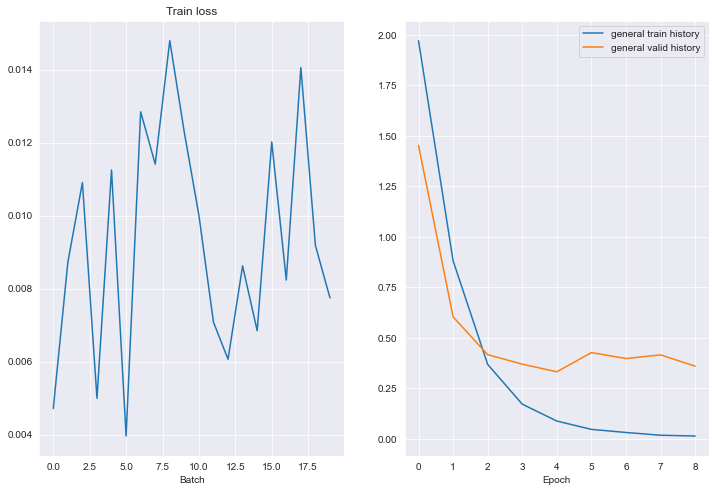

Epoch: 10 | Time: 0m 1s
	Train Loss: 0.010 | Train PPL:   1.010
	 Val. Loss: 0.453 |  Val. PPL:   1.573


In [219]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [220]:
model.load_state_dict(torch.load('val-model.pt'))

<All keys matched successfully>

### Применение модели

In [221]:
def accuracy_model(model, iterator):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            words = vars(batch)['words']    # [sent len, batch size]
            tags = vars(batch)['tags']      # [sent len, batch size]

            output = model(words)           # [sent len, batch size, output dim]

            output = output.argmax(dim=-1)  # [sent len, batch size]

            predict_tags = output.cpu().numpy()
            true_tags = tags.cpu().numpy()

            true_pred += np.sum((true_tags == predict_tags) & (true_tags != PAD_IDX))
            num_pred += np.prod(true_tags.shape) - (true_tags == PAD_IDX).sum()
        
    return round(true_pred / num_pred * 100, 3)

Пример решение нашей задачи:

In [222]:
def print_tags(model, data):
    model.eval()

    with torch.no_grad():
        words, _ = data
        example = torch.LongTensor([WORD.vocab.stoi[elem] for elem in words]).unsqueeze(1).to(device)

        output = model(example).argmax(dim=-1).cpu().numpy()
        tags = [TAG.vocab.itos[int(elem)] for elem in output]

        for token, tag in zip(words, tags):
            print(f'{token:15s}{tag}')

In [223]:
print_tags(model, pos_data[-1])

From           ADV
what           DET
I              NOUN
was            VERB
able           ADJ
to             ADP
gauge          NOUN
in             ADP
a              DET
swift          ADJ
,              .
greedy         ADJ
glance         NOUN
,              .
the            DET
figure         NOUN
inside         ADP
the            DET
coral-colored  ADJ
boucle         NOUN
dress          NOUN
was            VERB
stupefying     VERB
.              .


In [224]:
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 90.227 %


### Full brown corpus

Обучим BiLSTMTagger на полном корпусе:

In [92]:
# изменим структуру данных
pos_data_full = [list(zip(*sent)) for sent in my_brown_tagged_sents_full]
print(pos_data_full[0])

[('the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', "atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'), ('DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.')]


In [93]:
# наши поля
WORD_full = Field(lower=True)
TAG_full = Field(unk_token=None)  # все токены нам известны

# создаем примеры
examples_full = []
for words, tags in pos_data_full:
    examples_full.append(torchtext.legacy.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD_full), ('tags', TAG_full)]))

In [94]:
# пример
print(vars(examples_full[0]))

{'words': ['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', "atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], 'tags': ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']}


In [95]:
# кладем примеры в наш датасет
dataset_full = torchtext.legacy.data.Dataset(examples_full, fields=[('words', WORD_full), ('tags', TAG_full)])

train_data_full, valid_data_full, test_data_full = dataset_full.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data_full.examples)}")
print(f"Number of validation examples: {len(valid_data_full.examples)}")
print(f"Number of testing examples: {len(test_data_full.examples)}")

Number of training examples: 45872
Number of validation examples: 5734
Number of testing examples: 5734


In [96]:
WORD_full.build_vocab(train_data_full, min_freq=1)
TAG_full.build_vocab(train_data_full)

print(f"Unique tokens in source (ru) vocabulary: {len(WORD_full.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG_full.vocab)}")

print(WORD_full.vocab.itos[::200])
print(TAG_full.vocab.itos)

Unique tokens in source (ru) vocabulary: 45088
Unique tokens in target (en) vocabulary: 13
['<unk>', 'got', 'future', 'reached', 'couple', 'pretty', 'financial', 'upper', 'rule', 'careful', 'extended', 'january', 'components', 'tissue', 'improvement', 'retired', 'accurate', 'testament', 'prevented', 'contributions', 'meals', 'utility', 'chances', 'bases', 'wines', 'shrugged', 'langford', 'consist', 'ticket', 'jar', 'adequately', 'ludie', 'beaches', 'lumumba', '20th', 'fighters', 'regulation', 'bryan', 'ingredients', 'roar', 'array', 'foamed', 'periodic', 'trio', 'chord', 'garland', 'newman', 'steer', 'alley', 'condensed', 'firmer', 'longing', 'propulsion', 'stunned', '7:30', 'canons', 'displaying', 'garments', 'kidney', 'peeled', 'seaman', 'totalitarian', '700', 'beaverton', 'collects', 'dregs', 'galleys', 'interrupt', 'mediterranean', 'percentages', 'replenish', 'snobbery', 'totals', '$25', 'all-out', 'bind', 'chasing', 'cross-licensing', 'donna', 'fascinate', 'grazing', 'impetuous', 

In [97]:
print(vars(train_data_full.examples[9]))

{'words': ['he', 'came', 'bounding', 'up', 'the', 'stairs', 'and', 'joined', 'the', 'dance', '.'], 'tags': ['PRON', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', 'CONJ', 'VERB', 'DET', 'NOUN', '.']}


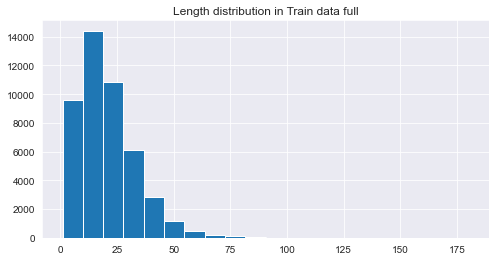

In [98]:
length = map(len, [vars(x)['words'] for x in train_data_full.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data full")
plt.hist(list(length), bins=20);

In [99]:
# разобьем нашу выборку на батчи, не забывая сначала отсортировать выборку по длине
train_iterator_full, valid_iterator_full, test_iterator_full = BucketIterator.splits(
    (train_data_full, valid_data_full, test_data_full),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=_len_sort_key)

In [100]:
# посморим  на количество батчей
list(map(len, [train_iterator_full, valid_iterator_full, test_iterator_full]))

[1434, 180, 180]

In [101]:
# параметры модели
INPUT_DIM = len(WORD_full.vocab)
OUTPUT_DIM = len(TAG_full.vocab)
EMB_DIM = 256
HID_DIM = 512
DROPOUT = 0.2
BIDIRECTIONAL = True

best_model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)
best_model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(45088, 256)
  (rnn): LSTM(256, 512, num_layers=2, bidirectional=True)
  (tag): Linear(in_features=1024, out_features=13, bias=True)
)

In [102]:
print(f'The model has {count_parameters(best_model):,} trainable parameters')

The model has 21,009,421 trainable parameters


In [106]:
PAD_IDX = TAG_full.vocab.stoi['<pad>']
best_optimizer = optim.Adam(best_model.parameters())
best_criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

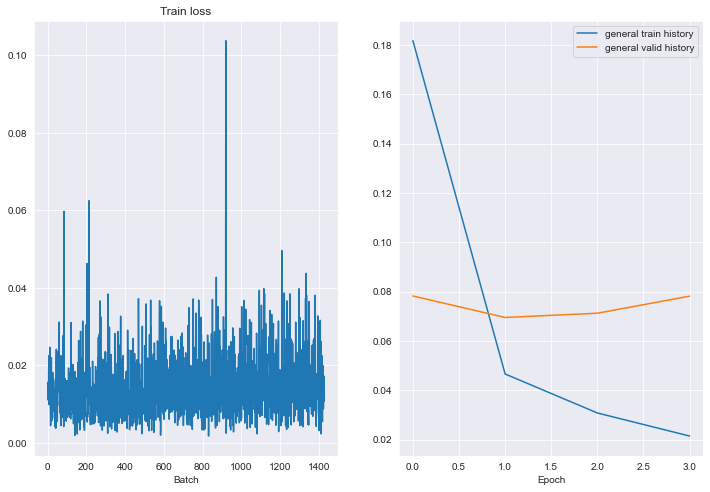

Epoch: 05 | Time: 1m 49s
	Train Loss: 0.015 | Train PPL:   1.015
	 Val. Loss: 0.081 |  Val. PPL:   1.085


In [104]:
train_history = []
valid_history = []

N_EPOCHS = 5
CLIP = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(best_model, train_iterator_full, best_optimizer, best_criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(best_model, valid_iterator_full, best_criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(best_model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [108]:
print("Accuracy:", accuracy_model(best_model, test_iterator_full), '%')

Accuracy: 97.71 %


Точность HiddenMarkov на категории 'humor' - 88.8%, на всём корпусе - 96.3%
Точность LstmTagger на категории 'humor' - 90.2%, на всём корпусе - 97.7%